In [33]:
from numpy import mean
from numpy import std
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import pandas as pd
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import argparse
import cv2
def resize(df):
	df=np.array(df,dtype='uint8')
	df=[cv2.resize(image,(32,32)) for image in df]
	df=np.array(df,dtype='float32')
	df=df.reshape((df.shape[0],32,32,1))
	return df

def load_dataset():
	df=pd.read_csv(r"C:\Users\prane\Desktop\2021_2022_2\ML\Assignment 1\CSV_datasetsix_vowel_dataset_with_class.csv")
	df=shuffle(df)
	pixels=[]
	for i in range(784):
		pixels.append('pixel'+str(i))
	features=pixels
	X=df.loc[:,features].values
	y=df.loc[:,'class'].values
	X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=100)
	trainX = X_train.reshape((X_train.shape[0], 28, 28, 1))
	testX = X_test.reshape((X_test.shape[0], 28, 28, 1))
	trainX=resize(trainX)
	testX=resize(testX)
	y_train=y_train-1
	y_test=y_test-1
	trainY = to_categorical(y_train)
	testY = to_categorical(y_test)
	trainX,validX,trainY,validY = train_test_split(trainX,trainY,test_size=0.1,random_state=100)
	validX=resize(validX)
	return trainX, trainY, testX, testY, validX, validY

In [9]:
EPOCHS = 50
INIT_LR = 1e-1
BS = 128

In [34]:
def prep_pixels(train, test, val):
	train_norm = train / 255.0
	test_norm = test / 255.0
	val_norm = val / 255.0
	return train_norm, test_norm, val_norm

class_labels = ['1','2','3','4','5','6']
trainX, trainY, testX, testY, validX, validY = load_dataset()
trainX, testX, validX = prep_pixels(trainX, testX, validX)

In [35]:
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")

In [36]:
from Resnet import ResNet
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, 6, (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

C:\Users\prane\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [37]:
classWeight={}
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(validX, validY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)

Epoch 1/50
7/7 [==============================] - 14s 2s/step - loss: 1.9309 - accuracy: 0.2382 - val_loss: 2.0449 - val_accuracy: 0.1389
Epoch 2/50
7/7 [==============================] - 10s 1s/step - loss: 1.8083 - accuracy: 0.3780 - val_loss: 2.1787 - val_accuracy: 0.1389
Epoch 3/50
7/7 [==============================] - 9s 1s/step - loss: 1.6853 - accuracy: 0.4656 - val_loss: 2.3588 - val_accuracy: 0.1389
Epoch 4/50
7/7 [==============================] - 9s 1s/step - loss: 1.5167 - accuracy: 0.5912 - val_loss: 2.5281 - val_accuracy: 0.1389
Epoch 5/50
7/7 [==============================] - 9s 1s/step - loss: 1.3979 - accuracy: 0.6363 - val_loss: 2.3203 - val_accuracy: 0.1389
Epoch 6/50
7/7 [==============================] - 10s 1s/step - loss: 1.2896 - accuracy: 0.7076 - val_loss: 1.6337 - val_accuracy: 0.3519
Epoch 7/50
7/7 [==============================] - 12s 2s/step - loss: 1.1838 - accuracy: 0.7227 - val_loss: 1.4709 - val_accuracy: 0.4907
Epoch 8/50
7/7 [=====================

In [38]:
_, acc = model.evaluate(testX, testY, verbose=0)
y_pred = model.predict(testX)
print('Test Accuracy:', (acc * 100), '%')

Test Accuracy: 99.16666746139526 %


In [39]:
def plot_metrics(history):
		pyplot.subplot(211)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(history.history['loss'], color='blue', label='train')
		pyplot.plot(history.history['val_loss'], color='red', label='validation')
		# plot accuracy
		pyplot.subplot(212)
		pyplot.title('Classification Accuracy')
		pyplot.plot(history.history['accuracy'], color='blue', label='train')
		pyplot.plot(history.history['val_accuracy'], color='red', label='validation')
		pyplot.tight_layout()
		pyplot.legend()
		pyplot.show()
	
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=pyplot.cm.Blues):
		pyplot.figure(figsize = (10,7))
		pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
		pyplot.title(title)
		pyplot.colorbar()
		tick_marks = np.arange(len(classes))
		pyplot.xticks(tick_marks, classes, rotation=90)
		pyplot.yticks(tick_marks, classes)
		if normalize:
			cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
		thresh = cm.max() / 2.
		for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
			pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
		pyplot.tight_layout()
		pyplot.ylabel('True label')
		pyplot.xlabel('Predicted label')

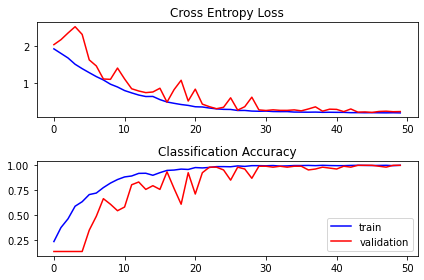

In [41]:
y_pred_classes = np.argmax(y_pred,axis = 1)
testY_classes = np.argmax(testY,axis = 1) 
confmat = confusion_matrix(testY_classes, y_pred_classes)
plot_metrics(H)

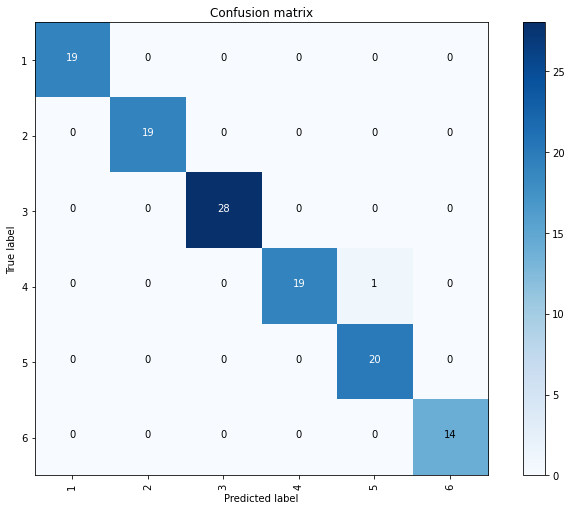

In [42]:
plot_confusion_matrix(confmat, classes = class_labels)